In [260]:
#api key
API_KEY ='0d02265676b10a2702f45b78f36b0e1b0840bb05eb4c436ecf217440c2b80254'

In [261]:
#instantiate XBRL api
import pandas as pd
from sec_api import XbrlApi

xbrlApi = XbrlApi(API_KEY)

In [3]:
#instantiate Query api
from sec_api import QueryApi

queryApi = QueryApi(api_key=API_KEY)

In [18]:
#grab filing URL
import pandas as pd


def standardize_filing_url(url):
  return url.replace('ix?doc=/', '')


def get_10K_metadata(start_year = 2021, end_year = 2022):
  frames = []

  for year in range(start_year, end_year + 1):
    number_of_objects_downloaded = 0

    for month in range(1, 13):
      padded_month = str(month).zfill(2) # "1" -> "01"
      date_range_filter = f'filedAt:[{year}-{padded_month}-01 TO {year}-{padded_month}-31]'
      form_type_filter  = f'formType:"10-K" AND NOT formType:("10-K/A", NT)'
      lucene_query = date_range_filter + ' AND ' + form_type_filter

      query_from = 0
      query_size = 200

      while True:
        query = {
          "query": lucene_query,
          "from": query_from,
          "size": query_size,
          "sort": [{ "filedAt": { "order": "desc" } }]
        }

        response = queryApi.get_filings(query)
        filings = response['filings']

        if len(filings) == 0:
          break
        else:
          query_from += query_size

        metadata = list(map(lambda f: {'ticker': f['ticker'], 
                                       'cik': f['cik'], 
                                       'formType': f['formType'], 
                                       'filedAt': f['filedAt'], 
                                       'filingUrl': f['linkToFilingDetails']
                                      }, filings))

        df = pd.DataFrame.from_records(metadata)
        # remove all entries without a ticker symbol
        df = df[df['ticker'].str.len() > 0]
        df['filingUrl'] = df['filingUrl'].apply(standardize_filing_url)
        frames.append(df)
        number_of_objects_downloaded += len(df)

    print(f'✅ Downloaded {number_of_objects_downloaded} metadata objects for year {year}')

  result = pd.concat(frames)

  print(f'✅ Download completed. Metadata downloaded for {len(result)} filings.')

  return result

In [25]:
#download metadata
metadata_10K = get_10K_metadata(start_year=2017, end_year=2018)

✅ Downloaded 5695 metadata objects for year 2017
✅ Downloaded 5683 metadata objects for year 2018
✅ Download completed. Metadata downloaded for 11378 filings.


In [26]:
#save metadata
metadata_10K.to_pickle('metadata_10K 2017_2018.pkl')

In [4]:
#split download per year
import pandas as pd
year='2021'
data=pd.read_pickle(f'metadata_10K 2021_2022.pkl')
data[data.filedAt.astype(str).str[:4]==year].to_pickle(f'json {year}.pkl')


In [2]:
import pandas as pd

In [ ]:
need to do 2017-2019; 2021-2022

In [272]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import concurrent.futures

def fetch_xbrl_json(url):
    try:
        xbrl_json = xbrlApi.xbrl_to_json(htm_url=url)
        return xbrl_json
    except:
        return np.nan
year=2020
# Initialize the new DataFrame with the correct columns
new_df = pd.DataFrame(columns=['cik', 'ticker', 'filedAt', 'json'])

# Load the data from the pickle file
data = pd.read_pickle(f'json {year}.pkl').reset_index()

# Using ThreadPoolExecutor for concurrent processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = {executor.submit(fetch_xbrl_json, row.filingUrl): index for index, row in data.iterrows()}
    results = []
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        index = futures[future]
        try:
            result = future.result()
        except Exception as e:
            result = np.nan
        results.append({
            'cik': data.at[index, 'cik'],
            'ticker': data.at[index, 'ticker'],
            'filedAt': data.at[index, 'filedAt'],
            'json': result
        })

new_df = pd.DataFrame(results)
new_df.to_pickle(f'json_fetched_{year}.pkl')

100%|██████████| 5526/5526 [13:53<00:00,  6.63it/s]  


In [10]:
data.head()

,index,ticker,cik,formType,filedAt,filingUrl,json
0,0,AMD,2488,10-K,2021-01-29T17:24:00-05:00,https://www.sec.gov/Archives/edgar/data/2488/0...,{'CoverPage': {'EntityCentralIndexKey': '00015...
1,2,ASTI,1350102,10-K,2021-01-29T16:02:57-05:00,https://www.sec.gov/Archives/edgar/data/135010...,"{'CoverPage': {'DocumentType': '10-K', 'Docume..."
2,3,DUSYF,1551887,10-K,2021-01-29T15:17:44-05:00,https://www.sec.gov/Archives/edgar/data/155188...,{'CoverPage': {'EntityRegistrantName': 'Digipa...
3,5,KSU,54480,10-K,2021-01-29T13:52:54-05:00,https://www.sec.gov/Archives/edgar/data/54480/...,{'CoverPage': {'EntityCentralIndexKey': '00002...
4,6,FREVS,36840,10-K,2021-01-29T13:29:05-05:00,https://www.sec.gov/Archives/edgar/data/36840/...,"{'CoverPage': {'DocumentType': '10-K', 'Docume..."


In [1]:
#loop for partial tag match
import pandas as pd
from tqdm import tqdm
import numpy as np

def check_for_partial_matches(df, key_to_check, delimiter=';'):
    def find_partial_matches(json_data, key_to_check, parent_key=None):
        matches = set()
        if isinstance(json_data, dict):
            for key, value in json_data.items():
                current_key = key if parent_key is None else f"{parent_key}.{key}"
                if key_to_check.lower() in key.lower():
                    matches.add(parent_key if parent_key else key)
                if isinstance(value, dict):
                    matches.update(find_partial_matches(value, key_to_check, current_key))
                elif isinstance(value, list):
                    for item in value:
                        if isinstance(item, dict):
                            matches.update(find_partial_matches(item, key_to_check, current_key))
        return matches

    col_name_match = f'contains_{key_to_check.lower()}'
    col_name_key = f'key_contains_{key_to_check.lower()}'

    # Apply the function to each row and collect matches
    df[col_name_key] = df['json'].apply(lambda x: delimiter.join(find_partial_matches(x, key_to_check)))
    df[col_name_match] = df[col_name_key].apply(lambda x: len(x) > 0)

    return df
key_to_check = 'BusinessCombinationRecognizedIdentifiableAssets'


for year in tqdm(np.arange(2020,2021)):
    data=pd.read_pickle(f'json_fetched_{year}.pkl')
# Check for partial matches in the json column
    result_partial_matches_df = check_for_partial_matches(data, key_to_check)
    result_partial_matches_df[result_partial_matches_df['contains_businesscombinationrecognizedidentifiableassets']==True].to_pickle(f'checked partial/partial_check{year}.pkl')

100%|██████████| 1/1 [05:48<00:00, 348.95s/it]


In [1]:
#loop for expanding the content of the tag
import pandas as pd
from pandas import json_normalize
import numpy as np
from tqdm import tqdm

# Function to flatten the DataFrame
def flatten_dataframe(df):
    rows = []
    for _, row in df.iterrows():
        details = row['details']
        if isinstance(details, list):
            for item in details:
                if isinstance(item, dict):
                    new_row = {**row.to_dict(), **item}
                else:
                    new_row = {**row.to_dict(), 'details': item}
                rows.append(new_row)
        elif isinstance(details, dict):
            new_row = {**row.to_dict(), **details}
            rows.append(new_row)
        else:
            new_row = row.to_dict()
            rows.append(new_row)
    return pd.DataFrame(rows)

# Function to process segments
def process_segments(segment):
    try:
        flattened_segment = json_normalize(segment)
        combined_values = flattened_segment.apply(lambda x: ';'.join(x.astype(str)), axis=1)
        return ';'.join(combined_values)
    except:
        return np.nan

# Initialize an empty list to store the results

for year in np.arange(2020,2021):
    all_expanded_dfs = []
    input=pd.read_pickle(f'/Users/jonathantanone/Purchased-intangibles/checked partial/partial_check{year}.pkl')
    # Loop through each row of the DataFrame
    for idx, row in tqdm(input.iterrows()):
        try:
            # Extract the input data from the JSON column
            input_data = row['json'][row['key_contains_businesscombinationrecognizedidentifiableassets']]
            
            # Create a DataFrame from the input data
            df = pd.DataFrame(input_data.items(), columns=['category', 'details'])
            
            # Flatten the DataFrame
            flattened_df = flatten_dataframe(df)
            
            # Remove prefixes from the 'category' column
            prefixes = [
                'BusinessCombinationRecognizedIdentifiableAssetsAcquiredAndLiabilitiesAssumed',
                'BusinessCombinationRecognizedIdentifiable',
                'BusinessCombinationIdentifiable',
                'BusinessCombinationRecognized',
                'BusinessCombination',
            ]
            for prefix in prefixes:
                flattened_df['category'] = flattened_df['category'].str.replace(f'^{prefix}', '', regex=True)
            try:
                # Process segments and add the results to the DataFrame
                flattened_df['segment_result'] = flattened_df['segment'].apply(process_segments)
                
                # Split the 'segment_result' column into multiple columns
                segment_columns = flattened_df['segment_result'].str.split(';', expand=True)
                segment_columns = segment_columns.rename(lambda x: f'segment_{x+1}', axis=1)
                
                # Combine the new columns with the original DataFrame
                expanded_df = pd.concat([flattened_df, segment_columns], axis=1)
                
                # Drop the original 'segment_result' column if it's no longer needed
                expanded_df = expanded_df.drop(columns=['segment_result'])
            except:
                expanded_df = flattened_df
            # Append the expanded DataFrame to the list
            all_expanded_dfs.append(expanded_df)
        except:
            all_expanded_dfs.append(pd.DataFrame(columns=['check']))

    # Concatenate all the expanded DataFrames
    input['table'] = all_expanded_dfs
    input.reset_index().iloc[:,1:].to_pickle(f'PPA tabulated/data_{year}.pkl')



1722it [00:06, 268.12it/s]


In [1]:
#loop for expanding the content
import pandas as pd
import numpy as np

def expand_table_skip_empty(df):
    expanded_df_list = []
    for index, row in df.iterrows():
        table_df = row['table']
        if not table_df.empty:
            table_df['ticker'] = row['ticker']
            table_df['cik'] = row['cik']
            table_df['filedAt'] = row['filedAt']
            expanded_df_list.append(table_df)
    
    if expanded_df_list:
        expanded_df = pd.concat(expanded_df_list, ignore_index=True)
    else:
        expanded_df = pd.DataFrame()  # Return an empty DataFrame if all tables are empty
    return expanded_df

for a in np.arange(2020,2021):
    data=pd.read_pickle(f'PPA tabulated/data_{a}.pkl')
    expanded_df=expand_table_skip_empty(data)
    expanded_df.to_pickle(f'expanded_df/ppa_expanded_{a}.pkl')


In [2]:
#data=pd.read_csv('expanded_df/ppa_expanded_2017.csv')

In [16]:
import pandas as pd

In [17]:
classification=pd.read_excel('/Users/jonathantanone/Downloads/unique_segments2.xlsx',sheet_name='Sheet1')

In [18]:
classification.Classification.unique()

array(['lease', 'advertising', 'cash', 'ppe', 'contract', 'core deposit',
       'customer', 'goodwill', 'intangible', 'r&d', 'marketing'],
      dtype=object)

In [19]:
import pandas as pd
data=pd.read_pickle('expanded_df/ppa_expanded_2020.pkl')

In [20]:
data

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,segment_3,...,segment_5,segment_6,segment_7,segment_8,xsi:nil,segment_9,segment_10,segment_11,segment_12,xs:nil
0,CashAndEquivalents,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,225000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AcquiredReceivablesGrossContractualAmount,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,260000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Inventory,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,1298000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CurrentAssetsOther,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,43000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PropertyPlantAndEquipment,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,36000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35666,PropertyPlantAndEquipmentUsefulLife,"[{'period': {'startDate': '2019-10-01', 'endDa...",NaN,NaN,"{'startDate': '2019-10-01', 'endDate': '2020-0...","{'dimension': 'srt:RangeAxis', 'value': 'srt:M...",P10Y,srt:RangeAxis,srt:MaximumMember,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35667,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2020-09-30'},NaN,7356822,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35668,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2019-09-30'},NaN,7527040,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35669,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2020-09-30'},{'dimension': 'us-gaap:StatementEquityComponen...,7356822,us-gaap:StatementEquityComponentsAxis,us-gaap:CommonStockMember,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
details

NameError: name 'details' is not defined

In [22]:

# Extract columns beginning with 'segment_'
segment_columns = [col for col in data.columns if col.startswith('segment_')]


# Check if any segment column contains 'us-gaap:BusinessAcquisitionAxis'
data['BusinessAcquisition'] = data[segment_columns].apply(
    lambda row: 1 if any('us-gaap:BusinessAcquisitionAxis'.lower() in str(value).lower() for value in row.values) else 0,
    axis=1
)

# Loop through each unique classification
for c in classification['Classification'].unique():
    # Get the corresponding detail for the classification
    details = classification[classification['Classification'] == c]['Detail'].values
    
    # Prefix 'us-gaap:' to each detail
    prefixed_details = [f'us-gaap:{detail}' for detail in details]
    
    # Check if 'BusinessAcquisition' is 1
    data[c] = data.apply(
        lambda row: 1 if row['BusinessAcquisition'] == 1 and any(
            any(detail.lower() in str(value).lower() for value in row[segment_columns].values) 
            for detail in prefixed_details
        ) else 0, axis=1
    )


In [23]:
list_seg=['lease', 'advertising', 'cash', 
       'contract', 'core deposit', 'customer', 'goodwill', 'intangible', 'r&d',
       'marketing', 'ppe']

In [24]:
data.columns

Index(['category', 'details', 'decimals', 'unitRef', 'period', 'segment',
       'value', 'segment_1', 'segment_2', 'segment_3', 'segment_4', 'ticker',
       'cik', 'filedAt', 'segment_5', 'segment_6', 'segment_7', 'segment_8',
       'xsi:nil', 'segment_9', 'segment_10', 'segment_11', 'segment_12',
       'xs:nil', 'BusinessAcquisition', 'lease', 'advertising', 'cash', 'ppe',
       'contract', 'core deposit', 'customer', 'goodwill', 'intangible', 'r&d',
       'marketing'],
      dtype='object')

In [25]:
data['sum_check'] = data[list_seg].sum(axis=1)


In [26]:
(data.sum_check==2).sum()

2

In [27]:
data.loc[24843,list_seg]

lease           0
advertising     0
cash            0
contract        0
core deposit    0
customer        0
goodwill        0
intangible      0
r&d             0
marketing       0
ppe             0
Name: 24843, dtype: object

In [28]:
data.segment[24843]

[{'dimension': 'us-gaap:PartnerTypeOfPartnersCapitalAccountAxis',
  'value': 'us-gaap:LimitedPartnerMember'},
 {'dimension': 'dei:LegalEntityAxis',
  'value': 'cbl:CBLAssociatesLimitedPartnershipMember'}]

In [29]:
data[data.sum_check==2]

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,segment_3,...,cash,ppe,contract,core deposit,customer,goodwill,intangible,r&d,marketing,sum_check
3987,FiniteLivedIntangibleAssetUsefulLife,"[{'period': {'startDate': '2018-04-01', 'endDa...",NaN,NaN,"{'startDate': '2018-05-01', 'endDate': '2018-0...",[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,P20Y,us-gaap:BusinessAcquisitionAxis,evop:NodusTechnologiesIncMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,1,1,2
25093,Intangibles,"{'decimals': '-5', 'unitRef': 'U_iso4217USD', ...",-5,U_iso4217USD,{'instant': '2014-12-31'},[{'dimension': 'us-gaap:FiniteLivedIntangibleA...,2400000,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,us-gaap:TradeNamesMember,us-gaap:IndefiniteLivedIntangibleAssetsByMajor...,...,0,0,0,0,0,0,1,0,1,2


In [30]:
(data.customer==1).sum()

405

In [31]:
data.iloc[57]

category                                                        Goodwill
details                [{'decimals': '-6', 'unitRef': 'usd', 'period'...
decimals                                                              -6
unitRef                                                              usd
period                                         {'instant': '2019-12-31'}
segment                {'dimension': 'us-gaap:StatementBusinessSegmen...
value                                                         1300000000
segment_1                          us-gaap:StatementBusinessSegmentsAxis
segment_2                                amzn:InternationalSegmentMember
segment_3                                                           None
segment_4                                                           None
ticker                                                              AMZN
cik                                                              1018724
filedAt                                        2020

In [32]:
data[data.sum_check==1]

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,segment_3,...,cash,ppe,contract,core deposit,customer,goodwill,intangible,r&d,marketing,sum_check
59,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2017-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,1987000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandSeventeenAcquisitionsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,0,1,1
60,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2018-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,186000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandEighteenAcquisitionsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,0,1,1
61,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2019-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,8000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandNineteenAcquisitionsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,0,1,1
62,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2017-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,440000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandSeventeenAcquisitionsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,1,0,0,0,0,0,0,1
63,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2018-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,13000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandEighteenAcquisitionsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35368,AcquiredFiniteLivedIntangibleAssetsWeightedAve...,"[{'period': {'startDate': '2019-10-01', 'endDa...",NaN,NaN,"{'startDate': '2019-10-01', 'endDate': '2020-0...",[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,P8Y,us-gaap:BusinessAcquisitionAxis,ford:IpsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,1,0,0,0,0,1
35369,AcquiredFiniteLivedIntangibleAssetsWeightedAve...,"[{'period': {'startDate': '2019-10-01', 'endDa...",NaN,NaN,"{'startDate': '2019-10-01', 'endDate': '2020-0...",[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,P15Y,us-gaap:BusinessAcquisitionAxis,ford:KablooeDesignMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,0,1,1
35545,Intangibles,"{'decimals': '-3', 'unitRef': 'Unit_Standard_U...",-3,Unit_Standard_USD_dtVrF2RoXES273qx4vRAcA,{'instant': '2019-06-07'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,250000,us-gaap:BusinessAcquisitionAxis,emkr:SystronDonnerInertialInc.Member,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,1,0,1
35546,AcquiredFiniteLivedIntangibleAssetsWeightedAve...,"{'period': {'startDate': '2019-06-07', 'endDat...",NaN,NaN,"{'startDate': '2019-06-07', 'endDate': '2019-0...",[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,P7Y,us-gaap:BusinessAcquisitionAxis,emkr:SystronDonnerInertialInc.Member,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,1,0,1


In [33]:
count_df=pd.DataFrame(columns=list_seg)
for s in list_seg:
    count_df.at[0,s]=len(data[data[s]==1].cik.unique())



In [34]:
data.loc[57,'cik']

'1018724'

In [35]:
len(data[data.sum_check>0].cik.unique())

204

In [36]:
count_df

,lease,advertising,cash,contract,core deposit,customer,goodwill,intangible,r&d,marketing,ppe
0,7,0,4,54,9,140,1,18,93,107,9


In [40]:
data[data.sum_check==1]

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,segment_3,...,cash,ppe,contract,core deposit,customer,goodwill,intangible,r&d,marketing,sum_check
59,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2017-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,1987000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandSeventeenAcquisitionsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,0,1,1
60,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2018-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,186000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandEighteenAcquisitionsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,0,1,1
61,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2019-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,8000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandNineteenAcquisitionsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,0,1,1
62,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2017-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,440000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandSeventeenAcquisitionsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,1,0,0,0,0,0,0,1
63,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2018-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,13000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandEighteenAcquisitionsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35368,AcquiredFiniteLivedIntangibleAssetsWeightedAve...,"[{'period': {'startDate': '2019-10-01', 'endDa...",NaN,NaN,"{'startDate': '2019-10-01', 'endDate': '2020-0...",[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,P8Y,us-gaap:BusinessAcquisitionAxis,ford:IpsMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,1,0,0,0,0,1
35369,AcquiredFiniteLivedIntangibleAssetsWeightedAve...,"[{'period': {'startDate': '2019-10-01', 'endDa...",NaN,NaN,"{'startDate': '2019-10-01', 'endDate': '2020-0...",[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,P15Y,us-gaap:BusinessAcquisitionAxis,ford:KablooeDesignMember,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,0,1,1
35545,Intangibles,"{'decimals': '-3', 'unitRef': 'Unit_Standard_U...",-3,Unit_Standard_USD_dtVrF2RoXES273qx4vRAcA,{'instant': '2019-06-07'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,250000,us-gaap:BusinessAcquisitionAxis,emkr:SystronDonnerInertialInc.Member,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,1,0,1
35546,AcquiredFiniteLivedIntangibleAssetsWeightedAve...,"{'period': {'startDate': '2019-06-07', 'endDat...",NaN,NaN,"{'startDate': '2019-06-07', 'endDate': '2019-0...",[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,P7Y,us-gaap:BusinessAcquisitionAxis,emkr:SystronDonnerInertialInc.Member,us-gaap:FiniteLivedIntangibleAssetsByMajorClas...,...,0,0,0,0,0,0,0,1,0,1


In [47]:
data.columns

Index(['category', 'details', 'decimals', 'unitRef', 'period', 'segment',
       'value', 'segment_1', 'segment_2', 'ticker', 'cik', 'filedAt',
       'segment_3', 'segment_4', 'segment_5', 'segment_6', 'segment_7',
       'segment_8', 'segment_9', 'segment_10', 'xsi:nil', 'segment_11',
       'segment_12', 'xs:nil', 'lease', 'check', 'advertising', 'ppe',
       'intellectual property', 'cash', 'tech', 'contract', 'core deposit',
       'customer', 'marketing', 'intangible', 'goodwill', 'tech equipment',
       'tech service'],
      dtype='object')

In [12]:
classification[classification['Classification'] == c]['Detail']

0        CollaborativeArrangementProductAgreementMember
1                   ContractBasedIntangibleAssetsMember
2     ContractsAccountedForUnderPercentageOfCompleti...
3                             ContractTerminationMember
4                               ContractualRightsMember
5                       DevelopedTechnologyRightsMember
6                              DistributionRightsMember
7                             EmploymentContractsMember
8                                 FranchisedUnitsMember
9                                       FranchiseMember
10                                FranchiseRightsMember
11                             GovernmentContractMember
12    InsuranceContractsAcquiredInBusinessCombinatio...
13    IntangibleAssetsArisingFromInsuranceContractsA...
14                                LeaseAgreementsMember
15                              LicenseAndServiceMember
16                                        LicenseMember
17                            LicensingAgreement

In [ ]:
###################################


#### CHECKING UNIQUE TAGS #########


###################################

In [ ]:
def check_tags(row):
    contains_business_acquisition_axis = row.isin(['us-gaap:BusinessAcquisitionAxis']).any()
    return int(contains_business_acquisition_axis)

# Apply the function to create the 'dummy' column
df['dummy'] = df.filter(like='segment_').apply(check_tags, axis=1)

# Get a list of every unique segment item in the dataframe
unique_segments = pd.unique(df.filter(like='segment_').values.ravel())


unique_segments

NameError: name 'df' is not defined

In [ ]:
import pandas as pd
data=pd.read_pickle('expanded_df/ppa_expanded_2020.pkl')

In [ ]:
import numpy as np
import pandas as pd

# Create an empty list to hold dataframes
dataframes = []

# Loop through the years and read each dataframe
for year in np.arange(2020, 2021):
    # Construct the file path
    file_path = f'expanded_df/ppa_expanded_{year}.pkl'
    
    try:
        # Read the dataframe
        df = pd.read_pickle(file_path)
        
        # Append the dataframe to the list
        dataframes.append(df)
    except FileNotFoundError:
        print(f"File not found: {file_path}")

# Concatenate all dataframes into one
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
   
    print("Combined DataFrame:")
    print(combined_df.head())
    print("\nUnique Segments:")
    print(unique_segments)
else:
    print("No dataframes to concatenate.")

Combined DataFrame:
                                    category  \
0                         CashAndEquivalents   
1  AcquiredReceivablesGrossContractualAmount   
2                                  Inventory   
3                         CurrentAssetsOther   
4                  PropertyPlantAndEquipment   

                                             details decimals unitRef  \
0  {'decimals': '-6', 'unitRef': 'usd', 'period':...       -6     usd   
1  {'decimals': '-6', 'unitRef': 'usd', 'period':...       -6     usd   
2  {'decimals': '-6', 'unitRef': 'usd', 'period':...       -6     usd   
3  {'decimals': '-6', 'unitRef': 'usd', 'period':...       -6     usd   
4  {'decimals': '-6', 'unitRef': 'usd', 'period':...       -6     usd   

                      period  \
0  {'instant': '2019-12-31'}   
1  {'instant': '2019-12-31'}   
2  {'instant': '2019-12-31'}   
3  {'instant': '2019-12-31'}   
4  {'instant': '2019-12-31'}   

                                             segment       

NameError: name 'unique_segments' is not defined

In [ ]:
combined_df

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,segment_3,...,segment_6,segment_7,segment_8,xsi:nil,segment_9,segment_10,segment_11,segment_12,xs:nil,dummy
0,CashAndEquivalents,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,225000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,AcquiredReceivablesGrossContractualAmount,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,260000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,Inventory,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,1298000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,CurrentAssetsOther,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,43000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,PropertyPlantAndEquipment,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,36000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35666,PropertyPlantAndEquipmentUsefulLife,"[{'period': {'startDate': '2019-10-01', 'endDa...",NaN,NaN,"{'startDate': '2019-10-01', 'endDate': '2020-0...","{'dimension': 'srt:RangeAxis', 'value': 'srt:M...",P10Y,srt:RangeAxis,srt:MaximumMember,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
35667,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2020-09-30'},NaN,7356822,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
35668,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2019-09-30'},NaN,7527040,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
35669,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2020-09-30'},{'dimension': 'us-gaap:StatementEquityComponen...,7356822,us-gaap:StatementEquityComponentsAxis,us-gaap:CommonStockMember,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:

# Define the check_tags function
def check_tags(row):
    segment_columns = row.filter(like='segment_')
    contains_business_acquisition_axis = segment_columns.isin(['us-gaap:BusinessAcquisitionAxis']).any()
    return int(contains_business_acquisition_axis)

# Apply the function to create the 'dummy' column
combined_df['dummy'] = combined_df.apply(check_tags, axis=1)

# Get a list of every unique segment item in the dataframe
unique_segments = pd.unique(combined_df.filter(like='segment_').values.ravel())

# Display the combined dataframe and unique segments

In [ ]:
# Function to extract the year from 'instant'
def extract_year(period):
    if isinstance(period, dict) and 'instant' in period:
        return period['instant'][:4]
    return None

# Apply the function to create a new column with the extracted year
combined_df['year'] = combined_df['period'].apply(extract_year)

In [ ]:
pd.DataFrame(unique_segments).to_csv('unique_segments.csv')

In [ ]:
data.columns

Index(['category', 'details', 'decimals', 'unitRef', 'period', 'segment',
       'value', 'segment_1', 'segment_2', 'segment_3', 'segment_4', 'ticker',
       'cik', 'filedAt', 'segment_5', 'segment_6', 'segment_7', 'segment_8',
       'xsi:nil', 'segment_9', 'segment_10', 'segment_11', 'segment_12',
       'xs:nil'],
      dtype='object')

In [ ]:
combined_df[combined_df.ticker=='SGU']

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,segment_3,...,segment_7,segment_8,xsi:nil,segment_9,segment_10,segment_11,segment_12,xs:nil,dummy,year


In [ ]:
combined_df2=combined_df[(~combined_df.year.isna())]

In [ ]:
combined_df2

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,segment_3,...,segment_7,segment_8,xsi:nil,segment_9,segment_10,segment_11,segment_12,xs:nil,dummy,year
0,CashAndEquivalents,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,225000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2019
1,AcquiredReceivablesGrossContractualAmount,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,260000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2019
2,Inventory,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,1298000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2019
3,CurrentAssetsOther,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,43000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2019
4,PropertyPlantAndEquipment,"{'decimals': '-6', 'unitRef': 'usd', 'period':...",-6,usd,{'instant': '2019-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,36000000,us-gaap:BusinessAcquisitionAxis,ba:KLXInc.Member,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35647,Assets,"[{'unitRef': 'Unit_USD', 'decimals': '-6', 'pe...",-5,Unit_USD,{'instant': '2019-10-25'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,700000,us-gaap:BusinessAcquisitionAxis,hnna:BpCapitalFundAdvisorsLlcMember,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2019
35664,ShareBasedCompensationArrangementByShareBasedP...,"{'unitRef': 'Unit_shares', 'decimals': 'INF', ...",INF,Unit_shares,{'instant': '2020-09-30'},NaN,3678411,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2020
35667,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2020-09-30'},NaN,7356822,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2020
35668,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2019-09-30'},NaN,7527040,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2019


In [ ]:
combined_df2['dummy']=combined_df2.apply(check_tags,axis=1)

/var/folders/00/q80vtjnd0bv_yp6wck36g7w40000gn/T/ipykernel_5907/4274397450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df2['dummy']=combined_df2.apply(check_tags,axis=1)


In [ ]:
combined_df2[combined_df2.dummy==1].drop_duplicates(['cik','year']).groupby(['year']).count().category

year
2003      1
2005      1
2008      2
2009      1
2010      3
2011      3
2013      4
2014      7
2015      8
2016      8
2017    155
2018    349
2019    423
2020     85
2021      2
Name: category, dtype: int64

<Axes: xlabel='year'>

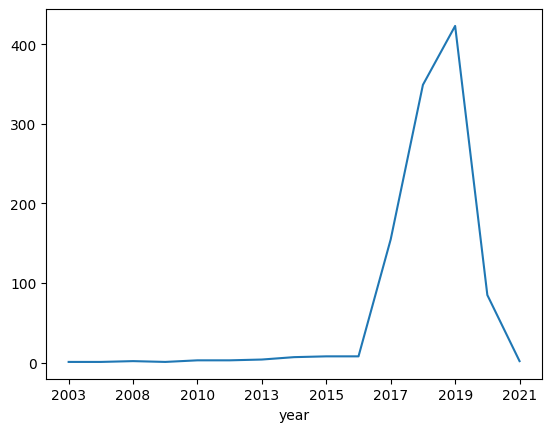

In [ ]:
combined_df2[combined_df2.dummy==1].drop_duplicates(['cik','year']).groupby(['year']).count().category.plot()

In [ ]:
unique_segments2 = pd.unique(combined_df.filter(like='segment_').values.ravel())

In [ ]:
pd.DataFrame(unique_segments2).to_csv('unique_segments2.csv')

In [ ]:
##########################


##### SCRATCH CODE   #####


##########################

In [30]:
data[(data.dummy==1) & (data['category'].astype(str).str.contains('intangible', case=False))]

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,ticker,...,segment_4,xs:nil,xsi:nil,segment_5,segment_6,segment_7,segment_8,segment_9,segment_10,dummy
33,Intangibles,"[{'decimals': '-5', 'unitRef': 'usd', 'period'...",-5,usd,{'instant': '2016-11-30'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,168300000,us-gaap:BusinessAcquisitionAxis,info:CARPROOFacquisitionMember,ISCB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
34,Intangibles,"[{'decimals': '-5', 'unitRef': 'usd', 'period'...",-5,usd,{'instant': '2016-11-30'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,3288800000,us-gaap:BusinessAcquisitionAxis,info:MarkitacquisitionMember,ISCB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
35,Intangibles,"[{'decimals': '-5', 'unitRef': 'usd', 'period'...",-5,usd,{'instant': '2016-11-30'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,200300000,us-gaap:BusinessAcquisitionAxis,info:OPISacquisitionMember,ISCB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
105,Intangibles,"{'decimals': '-5', 'unitRef': 'usd', 'period':...",-5,usd,{'instant': '2015-01-27'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,204400000,us-gaap:BusinessAcquisitionAxis,adbe:FotoliaMember,HEOL,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
112,IntangibleAssetsOtherThanGoodwill,"{'decimals': '-3', 'unitRef': 'iso4217-usd', '...",-3,iso4217-usd,{'instant': '2015-02-02'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,6362000,us-gaap:BusinessAcquisitionAxis,bset:ZenithFreightLinesMember,BSET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36371,IntangibleAssetsOtherThanGoodwill,"{'decimals': '-3', 'unitRef': 'usd', 'period':...",-3,usd,{'instant': '2017-09-29'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,6706000,us-gaap:BusinessAcquisitionAxis,jout:SeabearAndNorthportMember,AVXL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
36398,IndefinitelivedIntangibleAssetsAcquired,"[{'decimals': '-3', 'unitRef': 'usd', 'period'...",-3,usd,"{'startDate': '2016-09-26', 'endDate': '2017-0...",{'dimension': 'us-gaap:BusinessAcquisitionAxis...,2445000,us-gaap:BusinessAcquisitionAxis,lee:A2017AcquisitionMember,NVOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
36419,IntangibleAssetsOtherThanGoodwill,"[{'unitRef': 'iso4217_USD', 'decimals': '-5', ...",-5,iso4217_USD,{'instant': '2016-09-30'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,5700000,us-gaap:BusinessAcquisitionAxis,sgu:HeatingOilMotorFuelAndPropaneDealerMember,NGVC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
36420,IntangibleAssetsOtherThanGoodwill,"[{'unitRef': 'iso4217_USD', 'decimals': '-5', ...",-5,iso4217_USD,{'instant': '2017-09-30'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,37500000,us-gaap:BusinessAcquisitionAxis,sgu:HeatingOilDealerAndPropaneDealerAndPlumbin...,NGVC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [23]:
data[(data.dummy==1) ].category.unique()

array(['BusinessAcquisitionEquityInterestsIssuedOrIssuableNumberOfSharesIssued',
       'Mergerpricepershare',
       'ConsiderationTransferredEquityInterestsIssuedAndIssuable', ...,
       'DeferredCost', 'AdditionalDisclosuresWorkingCapital',
       'ProceedsFromContributedCapital'], dtype=object)

In [5]:
data

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,ticker,...,segment_5,segment_6,segment_7,segment_8,segment_9,segment_10,xsi:nil,segment_11,segment_12,xs:nil
0,ConsiderationTransferred1,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,"{'startDate': '2019-02-01', 'endDate': '2019-0...",{'dimension': 'us-gaap:BusinessAcquisitionAxis...,93000000,us-gaap:BusinessAcquisitionAxis,ebay:Motors.co.ukMember,BTIM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ConsiderationTransferred1,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,"{'startDate': '2018-01-01', 'endDate': '2018-1...",{'dimension': 'us-gaap:BusinessAcquisitionAxis...,306000000,us-gaap:BusinessAcquisitionAxis,ebay:GlosisMember,BTIM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BusinessAcquisitionPercentageOfVotingInterests...,"{'decimals': 'INF', 'unitRef': 'pure', 'period...",INF,pure,{'instant': '2018-12-31'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,1,us-gaap:BusinessAcquisitionAxis,ebay:GlosisMember,BTIM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Goodwill,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2019-12-31'},NaN,5153000000,NaN,NaN,BTIM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Goodwill,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2018-12-31'},NaN,5160000000,NaN,NaN,BTIM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36498,PropertyPlantAndEquipmentUsefulLife,"[{'period': {'startDate': '2019-10-01', 'endDa...",NaN,NaN,"{'startDate': '2019-10-01', 'endDate': '2020-0...","{'dimension': 'srt:RangeAxis', 'value': 'srt:M...",P10Y,srt:RangeAxis,srt:MaximumMember,COHR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36499,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2020-09-30'},NaN,7356822,NaN,NaN,COHR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36500,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2019-09-30'},NaN,7527040,NaN,NaN,COHR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36501,CommonStockSharesOutstanding,"[{'unitRef': 'Unit_shares', 'decimals': 'INF',...",INF,Unit_shares,{'instant': '2020-09-30'},{'dimension': 'us-gaap:StatementEquityComponen...,7356822,us-gaap:StatementEquityComponentsAxis,us-gaap:CommonStockMember,COHR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
import pandas as pd

# Function to check if 'us-gaap:BusinessAcquisitionAxis' and any other tag are present
def check_tags(row):
    contains_business_acquisition_axis = row.isin(['us-gaap:BusinessAcquisitionAxis']).any()
    contains_target_values = row.isin(target_values).any()
    return int(contains_business_acquisition_axis and contains_target_values)

# Apply the function to create the 'dummy' column
df['dummy'] = df.filter(like='segment_').apply(check_tags, axis=1)


In [25]:
df[df['dummy']==1]

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,ticker,...,segment_6,segment_7,segment_8,segment_9,segment_10,xsi:nil,segment_11,segment_12,xs:nil,dummy
57,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2017-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,1987000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandSeventeenAcquisitionsMember,DFCO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
58,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2018-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,186000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandEighteenAcquisitionsMember,DFCO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
59,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2019-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,8000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandNineteenAcquisitionsMember,DFCO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
60,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2017-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,440000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandSeventeenAcquisitionsMember,DFCO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
61,Intangibles,"[{'decimals': '-6', 'unitRef': 'usd', 'period'...",-6,usd,{'instant': '2018-12-31'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,13000000,us-gaap:BusinessAcquisitionAxis,amzn:TwoThousandEighteenAcquisitionsMember,DFCO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36191,Intangibles,"[{'unitRef': 'USD', 'decimals': '0', 'period':...",0,USD,{'instant': '2020-08-17'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,110000,us-gaap:BusinessAcquisitionAxis,ford:IpsMember,KEYS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
36207,AcquiredFiniteLivedIntangibleAssetsWeightedAve...,"[{'period': {'startDate': '2019-10-01', 'endDa...",NaN,NaN,"{'startDate': '2019-10-01', 'endDate': '2020-0...",[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,P8Y,us-gaap:BusinessAcquisitionAxis,ford:IpsMember,KEYS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
36208,AcquiredFiniteLivedIntangibleAssetsWeightedAve...,"[{'period': {'startDate': '2019-10-01', 'endDa...",NaN,NaN,"{'startDate': '2019-10-01', 'endDate': '2020-0...",[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,P15Y,us-gaap:BusinessAcquisitionAxis,ford:KablooeDesignMember,KEYS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
36371,Intangibles,"{'decimals': '-3', 'unitRef': 'Unit_Standard_U...",-3,Unit_Standard_USD_dtVrF2RoXES273qx4vRAcA,{'instant': '2019-06-07'},[{'dimension': 'us-gaap:BusinessAcquisitionAxi...,250000,us-gaap:BusinessAcquisitionAxis,emkr:SystronDonnerInertialInc.Member,AGTX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [14]:
# Function to extract the year from 'instant'
def extract_year(period):
    if isinstance(period, dict) and 'instant' in period:
        return period['instant'][:4]
    return None

# Apply the function to create a new column with the extracted year
combined_df['year'] = combined_df['period'].apply(extract_year)

In [28]:
(~combined_df.year.isna()).sum()

133131

In [52]:
combined_df2

,category,details,decimals,unitRef,period,segment,value,segment_1,segment_2,ticker,...,segment_5,segment_6,segment_7,segment_8,segment_9,segment_10,segment_11,segment_12,dummy,year
30,Intangibles,"[{'decimals': '-5', 'unitRef': 'usd', 'period'...",-5,usd,{'instant': '2014-11-30'},NaN,88500000,NaN,NaN,ISCB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2014
31,Intangibles,"[{'decimals': '-5', 'unitRef': 'usd', 'period'...",-5,usd,{'instant': '2015-11-30'},NaN,139400000,NaN,NaN,ISCB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2015
35,Intangibles,"[{'decimals': '-5', 'unitRef': 'usd', 'period'...",-5,usd,{'instant': '2016-11-30'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,200300000,us-gaap:BusinessAcquisitionAxis,info:OPISacquisitionMember,ISCB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2016
105,Intangibles,"{'decimals': '-5', 'unitRef': 'usd', 'period':...",-5,usd,{'instant': '2015-01-27'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,204400000,us-gaap:BusinessAcquisitionAxis,adbe:FotoliaMember,HEOL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2015
118,AssetsAcquiredGoodwillAndLiabilitiesAssumedNet,"{'decimals': '-3', 'unitRef': 'iso4217-usd', '...",-3,iso4217-usd,{'instant': '2015-02-02'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,32181000,us-gaap:BusinessAcquisitionAxis,bset:ZenithFreightLinesMember,BSET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210443,IntangibleAssetsOtherThanGoodwill,"{'decimals': '-5', 'unitRef': 'U_USD', 'period...",-5,U_USD,{'instant': '2022-09-30'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,7300000,us-gaap:BusinessAcquisitionAxis,sgu:HeatingOilDealersMember,HPE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2022
210448,IntangibleAssetsIncludingGoodwill,"[{'decimals': '-5', 'unitRef': 'U_USD', 'perio...",-5,U_USD,{'instant': '2021-09-30'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,37300000,us-gaap:BusinessAcquisitionAxis,sgu:HeatingOilDealersMember,HPE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2021
210449,IntangibleAssetsIncludingGoodwill,"[{'decimals': '-5', 'unitRef': 'U_USD', 'perio...",-5,U_USD,{'instant': '2020-09-30'},{'dimension': 'us-gaap:BusinessAcquisitionAxis...,3200000,us-gaap:BusinessAcquisitionAxis,sgu:HeatingOilDealersMember,HPE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2020
210456,AssetsAcquiredGoodwillAndLiabilitiesAssumedLes...,"[{'decimals': '-3', 'unitRef': 'usd', 'period'...",-3,usd,{'instant': '2021-06-30'},NaN,92463000,NaN,NaN,CSPI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2021


In [42]:
import pandas as pd

In [6]:
tags=pd.read_csv('/Users/jonathantanone/Downloads/tags_2020.csv')

In [8]:
tags.tags

0        us-gaap:MarketingRelatedIntangibleAssetsMember
1           us-gaap:ContractBasedIntangibleAssetsMember
2         us-gaap:TechnologyBasedIntangibleAssetsMember
3         us-gaap:CustomerRelatedIntangibleAssetsMember
4                    us-gaap:IntellectualPropertyMember
5         us-gaap:InProcessResearchAndDevelopmentMember
6                   us-gaap:LeasesAcquiredInPlaceMember
7     us-gaap:LeasesAcquiredInPlaceMarketAdjustmentM...
8                   us-gaap:CustomerRelationshipsMember
9                    us-gaap:NoncompeteAgreementsMember
10                  us-gaap:OtherIntangibleAssetsMember
11                          us-gaap:CustomerListsMember
12                               us-gaap:GoodwillMember
13                                us-gaap:PatentsMember
14                             us-gaap:TradeNamesMember
15        us-gaap:ComputerSoftwareIntangibleAssetMember
16                      us-gaap:AboveMarketLeasesMember
17                             us-gaap:Trademark

In [256]:
data=pd.read_pickle(f'metadata_10K 2019_2020.pkl')

In [262]:
data[data.ticker=='DFCO'].filingUrl[7]

'https://www.sec.gov/Archives/edgar/data/725394/000168316820000305/dalrada_10k-063019.htm'

In [263]:
xbrl_json=xbrlApi.xbrl_to_json('https://www.sec.gov/Archives/edgar/data/725394/000168316820000305/dalrada_10k-063019.htm')

In [264]:
xbrl_json[]

{'CoverPage': {'DocumentType': '10-K',
  'AmendmentFlag': 'false',
  'DocumentPeriodEndDate': '2019-06-30',
  'DocumentFiscalPeriodFocus': 'FY',
  'DocumentFiscalYearFocus': '2019',
  'CurrentFiscalYearEndDate': '--06-30',
  'EntityFileNumber': '000-12641',
  'EntityRegistrantName': 'DALRADA FINANCIAL CORP',
  'EntityCentralIndexKey': '0000725394',
  'EntityWellKnownSeasonedIssuer': 'No',
  'EntityVoluntaryFilers': 'No',
  'EntityCurrentReportingStatus': 'No',
  'EntityInteractiveDataCurrent': 'No',
  'EntityFilerCategory': 'Non-accelerated Filer',
  'EntitySmallBusiness': 'true',
  'EntityEmergingGrowthCompany': 'false',
  'EntityShellCompany': 'false',
  'EntityPublicFloat': {'unitRef': 'USD',
   'decimals': '0',
   'period': {'instant': '2019-03-31'},
   'value': '1076915'},
  'EntityCommonStockSharesOutstanding': {'unitRef': 'Shares',
   'decimals': 'INF',
   'period': {'instant': '2020-01-30'},
   'value': '48028128'},
  'EntityIncorporationStateCountryCode': 'DE'},
 'BalanceSheet

In [265]:
data=pd.read_pickle('json_fetched_2020.pkl')

In [270]:
data[data.ticker=='DFCO'].json[7]

{'AcquisitionsGoodwillAndAcquiredIntangibleAssets': {'BusinessCombinationDisclosureTextBlock': 'ACQUISITIONS, GOODWILL, AND ACQUIRED INTANGIBLE ASSETS<div style="line-height:120%;padding-top:6px;text-indent:16px;font-size:10pt;"><span style="font-family:inherit;font-size:10pt;font-style:italic;font-weight:bold;">2017 Acquisition Activity </span></div><div style="line-height:120%;padding-top:6px;text-align:left;text-indent:30px;font-size:10pt;"><span style="font-family:inherit;font-size:10pt;">On </span><span style="font-family:inherit;font-size:10pt;">May\xa012, 2017</span><span style="font-family:inherit;font-size:10pt;">, we acquired Souq Group Ltd., an e-commerce company, for approximately </span><span style="font-family:inherit;font-size:10pt;"><span>$583 million</span></span><span style="font-family:inherit;font-size:10pt;">, net of cash acquired, and on August 28, 2017, we acquired Whole Foods Market, a grocery store chain, for approximately </span><span style="font-family:inheri

In [ ]:
#loop for xbrl fetch
import numpy as np
import pandas as pd
from tqdm import tqdm
import concurrent.futures
# Function to fetch xbrl_json
def fetch_xbrl_json(url):
    try:
        xbrl_json = xbrlApi.xbrl_to_json(htm_url=url)
        return xbrl_json
    except:
        return np.nan
for year in np.arange(2017,2023):

    # List to store JSON results
    data=pd.read_pickle(f'json {year}.pkl').reset_index()
    json_list = []

    # Using ThreadPoolExecutor for concurrent processing
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(fetch_xbrl_json, row.filingUrl) for index, row in data.iterrows()]
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            json_list.append(future.result())

    data['json'] = json_list
    data.to_pickle(f'json_fetched_{year}.pkl')

100%|██████████| 5526/5526 [13:14<00:00,  6.95it/s]  


: 

In [8]:
#fetch XBRL
import numpy as np
import pandas as pd
from tqdm import tqdm
import concurrent.futures
def fetch_xbrl_json(url):
    try:
        xbrl_json = xbrlApi.xbrl_to_json(htm_url=url)
        return xbrl_json
    except:
        return np.nan
json_list = []


data=pd.read_pickle('json 2021.pkl').reset_index()


# Using ThreadPoolExecutor for concurrent processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(fetch_xbrl_json, row.filingUrl) for index, row in data.iterrows()]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        json_list.append(future.result())
data['json'] = json_list
data.to_pickle('json_fetched_2021.pkl')

100%|██████████| 5997/5997 [13:42<00:00,  7.29it/s]  
